#**TASK A: BINARY SEXISM DETECTION**

In [1]:
pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.10.1-py3-none-any.whl (226 kB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


# **Library Imports**

In [13]:
import numpy as np
import pandas as pd
import re, string
import matplotlib.pyplot as plt
from tensorflow import keras 
import tensorflow as tf
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.ticker as ticker
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

## **Loading Dataset**

In [14]:
df = pd.read_csv ('train_all_tasks.csv')
df.head (5)

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",not sexist,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,not sexist,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,not sexist,none,none


# **Exploratory Data Analysis**

In [15]:
#Exploraing the data
print( 'The shape of the dataset: ', df.shape )

print( '\nDataset description:\n {}'.format( df.describe () ) )

print(".......................................................................")

print( '\nSexist unique values count:\r\n {}\n'.format( df ['label_sexist'].value_counts() ) )
print( 'Category unique values count:\r\n {}\n'.format( df ['label_category'].value_counts() ) )

print( df.isnull().sum() )
print('\nno of rows with null values in text column: ', df['text'].isnull().sum())
print('no of rows with null values in label_sexist column: ', df['label_sexist'].isnull().sum())
print('no of rows with null values in label_category column: ', df['label_category'].isnull().sum())

print("\n.......................................................................\n")

duplicate = df.duplicated('text')
print("How many duplicate texts are there: \n", duplicate.value_counts())    #No duplicate texts


The shape of the dataset:  (14000, 5)

Dataset description:
                       rewire_id                                   text  \
count                     14000                                  14000   
unique                    14000                                  14000   
top     sexism2022_english-7358  Damn, this writing was pretty chaotic   
freq                          1                                      1   

       label_sexist label_category label_vector  
count         14000          14000        14000  
unique            2              5           12  
top      not sexist           none         none  
freq          10602          10602        10602  
.......................................................................

Sexist unique values count:
 not sexist    10602
sexist         3398
Name: label_sexist, dtype: int64

Category unique values count:
 none                                        10602
2. derogation                                1590
3. animosit

## **Pie Chart to view data distribution**

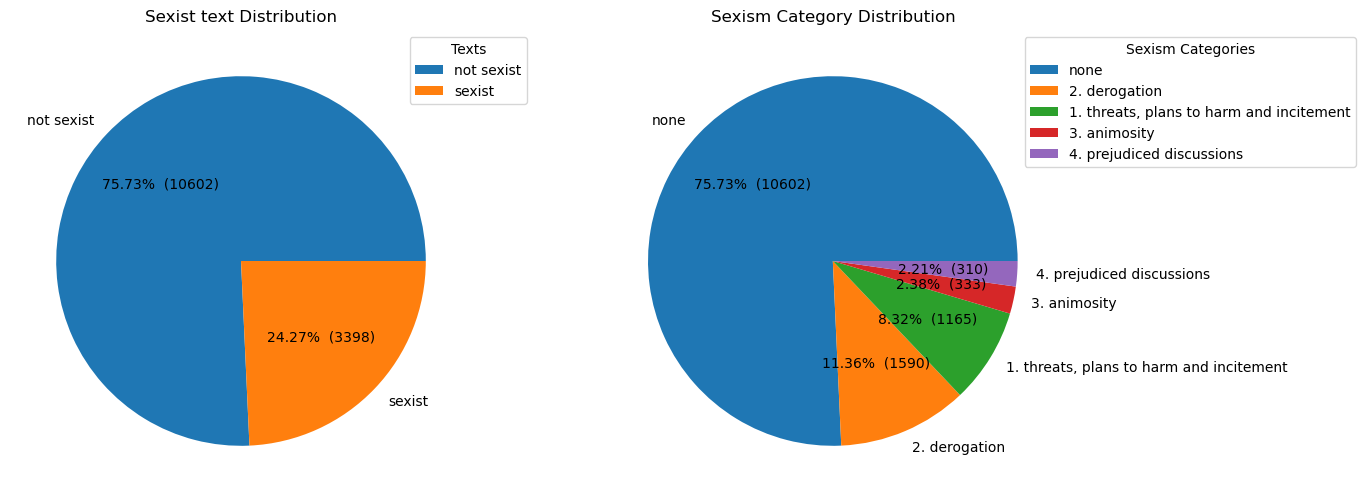

In [16]:
#Pie chart to plot how sexist and non-sexist texts are distributed
fig = plt.figure(figsize =(14, 6))

plt.subplot(1, 2, 1)
plt.title("Sexist text Distribution")

plt.pie ( df['label_sexist'].value_counts(), labels = df['label_sexist'].unique().tolist(),   
         autopct = lambda p : '{:.2f}%  ({:.0f})'.format( p, p * sum(df ['label_sexist'].value_counts()) / 100 ) )

# Adding legend
plt.legend (title ="Texts", loc ="upper left", bbox_to_anchor =(0.85, 0, 0.5, 1))


plt.subplot(1, 2, 2)
plt.title("Sexism Category Distribution")

plt.pie ( df['label_category'].value_counts(), labels = df['label_category'].unique().tolist(),   
         autopct = lambda p : '{:.2f}%  ({:.0f})'.format( p, p * sum(df ['label_category'].value_counts()) / 100 ) )

plt.legend (title ="Sexism Categories", loc ="upper left", bbox_to_anchor =(0.9, 0, 0.5, 1))

plt.show() 

## **Data Cleaning & Dropping column**

In [17]:
# removing special chars
def clean_text():
    clean = re.compile('<.*?>')

    df['text'] = df['text'].apply(lambda x: x.lower())
    df['text'] = df['text'].apply((lambda x: re.sub(clean, ' ', x)))
    df['text'] = df['text'].apply((lambda x: re.sub('https://.*', ' ', x)))
    # df['text'] = df['text'].apply((lambda x: re.sub('\.+', ' ', x)))         #not removing punctuations as model performs better without removal
    # df['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))

clean_text()


# Drops unnecessary or null columns
def drop_column(columns):
    global df
    df = df.drop(columns, axis = 1)

# Drops null rows
def drop_rows(columns):
    global df
    df = df.dropna(axis = 0, subset = columns)


drop = ['rewire_id']
drop_column(drop)

print( '\nThe shape of this dataset is now: {}\n'.format( df.shape ) )
df.tail()


The shape of this dataset is now: (14000, 4)



,text,label_sexist,label_category,label_vector
13995,complexes like the 'nice chicks' that go after...,sexist,2. derogation,2.1 descriptive attacks
13996,"""graphic germany - muslim ""refugee"" stabbing h...",not sexist,none,none
13997,lol i imagine there would be simps that are li...,not sexist,none,none
13998,"it's not, the girls i go on dates with don't k...",not sexist,none,none
13999,how can he be an incel? he does have a girlfri...,not sexist,none,none


# **Data Preprocessing**

## **Data Labeling**

In [18]:
# for sexism labeling as binary or categorical values

label_binary = {
    'not sexist': 0,
    'sexist': 1,
    }

label_categorical = {
    'none': 0,
    '1. threats, plans to harm and incitement': 1,
    '2. derogation': 2,
    '3. animosity': 3,
    '4. prejudiced discussions': 4,
    }


df ['binary_sexism'] = df ['label_sexist'].apply( lambda x : label_binary [x] )
df ['category_sexism'] = df ['label_category'].apply( lambda x : label_categorical [x] )

df.tail()

,text,label_sexist,label_category,label_vector,binary_sexism,category_sexism
13995,complexes like the 'nice chicks' that go after...,sexist,2. derogation,2.1 descriptive attacks,1,2
13996,"""graphic germany - muslim ""refugee"" stabbing h...",not sexist,none,none,0,0
13997,lol i imagine there would be simps that are li...,not sexist,none,none,0,0
13998,"it's not, the girls i go on dates with don't k...",not sexist,none,none,0,0
13999,how can he be an incel? he does have a girlfri...,not sexist,none,none,0,0


## **Stopwords removal & Lemmatization (not used)**
Model performs better without it so decided against stopwords removal and lemmatization

In [19]:
# # removing the stopwords

# nltk.download('stopwords')

# stop_words = nltk.corpus.stopwords.words('english')

# print( '\n{}\n'.format( stop_words ) )

# df['cleaned_stwds'] = df['text'].apply( lambda x: " ".join (word for word in x.split() if word not in stop_words) )

# # pd.Series( " ".join( df['cleaned_stwds'] ).split() ).value_counts()[:20]


# #lemmatization

# nltk.download('wordnet')
# nltk.download('omw-1.4')
# lemmatizer = nltk.stem.WordNetLemmatizer()

# df['lemmatizer'] = df['cleaned_stwds'].apply( lambda x: [ lemmatizer.lemmatize(word) for word in x.split() ] )
# df['text_processed'] = df['lemmatizer'].apply( lambda x: " ".join (x) )

# df.tail()

# **Train-Validation-Test split**

In [20]:
#Train-valdation-test split
x = df['text']
y = df['binary_sexism']

x_train, x_hold, y_train, y_hold = train_test_split (x, y, random_state = 42, test_size = 0.20, shuffle=True, stratify=y)
x_test, x_val, y_test, y_val = train_test_split (x_hold, y_hold, test_size = 0.50, random_state = 42, shuffle= True, stratify = y_hold)

# print('..........', len(y) )

print ( "Training Data size: x_train {}  y_train {}".format( x_train.shape, y_train.shape ), ' - {}%'.format( ( len(x_train) / len(y) ) * 100 ) )
print ( "Validation Data size: x_val {}, y_val {}".format( x_val.shape, y_val.shape ), ' - {}%'.format( ( len(x_val) / len(y) ) * 100 ) )
print ( "Testing Data size: x_test {}  y_test {}".format( x_test.shape, y_test.shape ), ' - {}%\n'.format( (  len(x_test) / len(y) ) * 100 ) )

print( 'y_train unique values counts:\n{}\n'.format( y_train.value_counts() ) )
print( 'y_val unique values counts:\n{}\n'.format( y_val.value_counts() ) )
print( 'y_test unique values counts:\n{}\n'.format( y_test.value_counts() ) )

print( x_train[3] )
print( y_train[3] )

Training Data size: x_train (11200,)  y_train (11200,)  - 80.0%
Validation Data size: x_val (1400,), y_val (1400,)  - 10.0%
Testing Data size: x_test (1400,)  y_test (1400,)  - 10.0%

y_train unique values counts:
0    8482
1    2718
Name: binary_sexism, dtype: int64

y_val unique values counts:
0    1060
1     340
Name: binary_sexism, dtype: int64

y_test unique values counts:
0    1060
1     340
Name: binary_sexism, dtype: int64

understand. know you're right. at same time i know there isn't enough money in the world to induce me to do an beastly female equivalent.
0


# **Text Tokenization**

In [21]:
#Tokenization
num_words = 3000

print( "\nX-train value index 3 (before tokenization): ", x_train[3] )

tokenizer = Tokenizer (num_words = num_words, lower = False)


def tokenization( x_train, x_val, x_test ):

  tokenizer.fit_on_texts (x_train)

  tokenized_xtrain = tokenizer.texts_to_sequences (x_train)
  tokenized_xval = tokenizer.texts_to_sequences (x_val)
  tokenized_xtest = tokenizer.texts_to_sequences (x_test)

  return tokenized_xtrain, tokenized_xval, tokenized_xtest

x_train, x_val, x_test = tokenization (x_train, x_val, x_test)


vocab = tokenizer.word_index
vocab_size = len( tokenizer.word_index ) + 1


print( "\n", vocab )
print( "\nThe size of Vocabulary: ", vocab_size )

# print( "\nX-train value: {}\n".format( x_train ) )
print( "\nX-train value index 3 (after tokenization): ", x_train[3] )
print( "Y-train value index 3: ", y_train[3] )



X-train value index 3 (before tokenization):  understand. know you're right. at same time i know there isn't enough money in the world to induce me to do an beastly female equivalent.

 {'the': 1, 'a': 2, 'to': 3, 'and': 4, 'i': 5, 'you': 6, 'of': 7, 'is': 8, 'her': 9, 'that': 10, 'in': 11, 'she': 12, 'women': 13, 'it': 14, 'for': 15, 'are': 16, 'with': 17, 'this': 18, 'be': 19, 'on': 20, 'they': 21, 'not': 22, 'have': 23, 'if': 24, 'like': 25, 'url': 26, 'but': 27, 'just': 28, 'as': 29, 'your': 30, 'my': 31, 'all': 32, 'was': 33, 'so': 34, 'or': 35, 'what': 36, 'do': 37, 'me': 38, 'woman': 39, 'get': 40, 'who': 41, 'about': 42, 'he': 43, 'no': 44, 'at': 45, 'men': 46, 'out': 47, 'up': 48, "don't": 49, 'can': 50, 'will': 51, 'user': 52, 'their': 53, 'would': 54, 'them': 55, "it's": 56, 'how': 57, 'an': 58, 'we': 59, 'by': 60, 'when': 61, 'because': 62, 'one': 63, 'has': 64, 'from': 65, 'girls': 66, 'girl': 67, 'fuck': 68, 'more': 69, 'his': 70, 'want': 71, 'white': 72, 'shit': 73, 'fe

## **Padding tokenized texts**

In [22]:
#Padding the tokenized reviews
def padding (x_train, x_val, x_test):
    maxlen = 50
    
    padded_xtrain = pad_sequences( x_train, padding = 'post', maxlen = maxlen )

    #   maxlen = len( padded_xtrain[0] )
    padded_xval = pad_sequences( x_val, padding = 'post', maxlen = maxlen )
    padded_xtest = pad_sequences( x_test, padding = 'post', maxlen = maxlen )

    return maxlen, padded_xtrain, padded_xval, padded_xtest

maxlen, x_train, x_val, x_test = padding( x_train, x_val, x_test )


print("max length of each padded texts: ", maxlen)

print( "\n[ x_train.shape[0], x_train.shape[1] ]: [ {}, {} ]".format ( x_train.shape[0], x_train.shape[1] ) )
print( "\n[ x_val.shape[0], x_val.shape[1] ]: [ {}, {} ]".format ( x_val.shape[0], x_val.shape[1] ) )
print( "\n[ x_test.shape[0], x_test.shape[1] ]: [ {}, {} ]\n".format ( x_test.shape[0], x_test.shape[1] ) )

print( "X-train row index 3:\n", x_train[3, :] )


max length of each padded texts:  50

[ x_train.shape[0], x_train.shape[1] ]: [ 11200, 50 ]

[ x_val.shape[0], x_val.shape[1] ]: [ 1400, 50 ]

[ x_test.shape[0], x_test.shape[1] ]: [ 1400, 50 ]

X-train row index 3:
 [ 434  247  601   27   15   56    1   85  356  377  102   66   32  134
   48    3    1  146 1819 1820    4  954   34    7  357   21   19  233
 2241 1708    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


## **Embedding matrix creation by GloVe embedding**

In [23]:
#func to create embedding_matrix through GloVe embedding
def create_embedding_matrix(filepath, word_index, embedding_dim):
    
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix


embedding_dim = 100
embedding_matrix = create_embedding_matrix( 'glove.6B.100d.txt', tokenizer.word_index, embedding_dim )

print("The embedding matrix with GLoVe embedding: \n", embedding_matrix)


#Non zero embedding vectors

nonzero_elements = np.count_nonzero( np.count_nonzero(embedding_matrix, axis=1) )
print( "Amount of nonzero embedding vectors: ", nonzero_elements / vocab_size )

The embedding matrix with GLoVe embedding: 
 [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.038194   -0.24487001  0.72812003 ... -0.1459      0.82779998
   0.27061999]
 [-0.27085999  0.044006   -0.02026    ... -0.4923      0.63687003
   0.23642001]
 ...
 [ 0.17428    -0.40492001  0.54396999 ... -0.39197999  0.12698001
  -0.65447998]
 [ 0.045521   -0.28689     0.23307    ... -0.041397   -0.52139997
  -0.024642  ]
 [ 0.40079001 -0.57675999  0.06379    ...  0.33825001 -0.037264
  -0.050584  ]]
Amount of nonzero embedding vectors:  0.8003102171520065


# **Using LSTM**

## **Simple lstm structure**

In [24]:
#Simple LSTM structure to check performance
def lstm_simple (dense, maxlen):  
    lstm_out = 128

    model = Sequential()
    model.add( layers.Embedding( vocab_size, embedding_dim, weights = [embedding_matrix], input_length = maxlen, trainable = True ) )
    model.add( layers.LSTM ( lstm_out, dropout = 0.2 ) )
    model.add( layers.Dense ( dense, activation ='sigmoid' ) )

    model.compile ( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'] )
    print ( model.summary() )

    return model

model = lstm_simple (1, maxlen)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           1998600   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,115,977
Trainable params: 2,115,977
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
#fitting model
batch_size = 32
history = model.fit( x_train, y_train, epochs = 20, verbose = True, validation_data = ( x_val, y_val ), batch_size = batch_size )

Epoch 1/20
350/350 [==============================] - 13s 34ms/step - loss: 0.5572 - accuracy: 0.7571 - val_loss: 0.5552 - val_accuracy: 0.7571
Epoch 2/20
350/350 [==============================] - 12s 34ms/step - loss: 0.4797 - accuracy: 0.7888 - val_loss: 0.4493 - val_accuracy: 0.8207
Epoch 3/20
350/350 [==============================] - 11s 32ms/step - loss: 0.4057 - accuracy: 0.8411 - val_loss: 0.4248 - val_accuracy: 0.8250
Epoch 4/20
350/350 [==============================] - 11s 33ms/step - loss: 0.3571 - accuracy: 0.8513 - val_loss: 0.4099 - val_accuracy: 0.8314
Epoch 5/20
350/350 [==============================] - 12s 33ms/step - loss: 0.3220 - accuracy: 0.8691 - val_loss: 0.4246 - val_accuracy: 0.8393
Epoch 6/20
350/350 [==============================] - 11s 33ms/step - loss: 0.2975 - accuracy: 0.8779 - val_loss: 0.4154 - val_accuracy: 0.8386
Epoch 7/20
350/350 [==============================] - 11s 32ms/step - loss: 0.2831 - accuracy: 0.8863 - val_loss: 0.4120 - val_accuracy:

In [26]:
loss, accuracy = model.evaluate( x_train, y_train, verbose = False )
print( "\nTraining Accuracy: {:.4f}, Training Loss: {:.4f}".format(accuracy, loss) )

loss, accuracy = model.evaluate( x_test, y_test, verbose = False )
print( "Testing Accuracy:  {:.4f}, Testing Loss: {:.4f}\n".format(accuracy, loss) )

# print(history.history)


Training Accuracy: 0.9827, Training Loss: 0.0808
Testing Accuracy:  0.8014, Testing Loss: 0.6324



## **LSTM model Hyperparameter tuned**

In [27]:
def lstm_hypertuned (dense, maxlen):  
    lstm_out = 128

    model = Sequential()

    model.add( layers.Embedding( vocab_size, embedding_dim, weights = [embedding_matrix], input_length = maxlen, trainable = True ) )
    model.add ( layers.SpatialDropout1D (0.4) )
    model.add( layers.LSTM ( lstm_out, dropout = 0.2, recurrent_dropout = 0.2, activation = 'tanh' ) )
    model.add( layers.Dense( 50, activation='relu' ) )
    model.add( layers.Dense ( dense, activation ='sigmoid' ) )

    model.compile ( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'] )
    print ( model.summary() )

    return model

model2 = lstm_hypertuned (1, maxlen)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 100)           1998600   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 100)          0         
 ropout1D)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 50)                6450      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,122,349
Trainable params: 2,122,349
Non-trainable params: 0
____________________________________________

In [28]:
#fitting model
batch_size = 64
history2 = model2.fit( x_train, y_train, epochs = 20, verbose = True, validation_data = ( x_val, y_val ), batch_size = batch_size )

Epoch 1/20
175/175 [==============================] - 13s 67ms/step - loss: 0.5610 - accuracy: 0.7555 - val_loss: 0.5533 - val_accuracy: 0.7571
Epoch 2/20
175/175 [==============================] - 11s 65ms/step - loss: 0.5561 - accuracy: 0.7573 - val_loss: 0.5520 - val_accuracy: 0.7571
Epoch 3/20
175/175 [==============================] - 12s 66ms/step - loss: 0.5420 - accuracy: 0.7571 - val_loss: 0.5020 - val_accuracy: 0.7693
Epoch 4/20
175/175 [==============================] - 12s 66ms/step - loss: 0.4498 - accuracy: 0.8011 - val_loss: 0.4186 - val_accuracy: 0.8264
Epoch 5/20
175/175 [==============================] - 11s 65ms/step - loss: 0.4038 - accuracy: 0.8291 - val_loss: 0.4121 - val_accuracy: 0.8343
Epoch 6/20
175/175 [==============================] - 11s 65ms/step - loss: 0.3705 - accuracy: 0.8437 - val_loss: 0.4014 - val_accuracy: 0.8400
Epoch 7/20
175/175 [==============================] - 12s 66ms/step - loss: 0.3540 - accuracy: 0.8508 - val_loss: 0.4323 - val_accuracy:

### **Training-Testing loss and accuracy**

In [29]:
loss, accuracy = model2.evaluate( x_train, y_train, verbose = False )
print( "\nTraining Accuracy: {:.4f}, Training Loss: {:.4f}".format(accuracy, loss) )

losstest, accuracytest = model2.evaluate( x_test, y_test, verbose = False )
print( "Testing Accuracy:  {:.4f}, Testing Loss: {:.4f}\n".format(accuracytest, losstest) )

#Storing the best results
best_lstm_accloss = [loss, accuracy, losstest, accuracytest, history2]

# print(history2.history)


Training Accuracy: 0.9302, Training Loss: 0.1770
Testing Accuracy:  0.8064, Testing Loss: 0.4900



### **Plotting Training & Validation loss & accuracy in Graph**

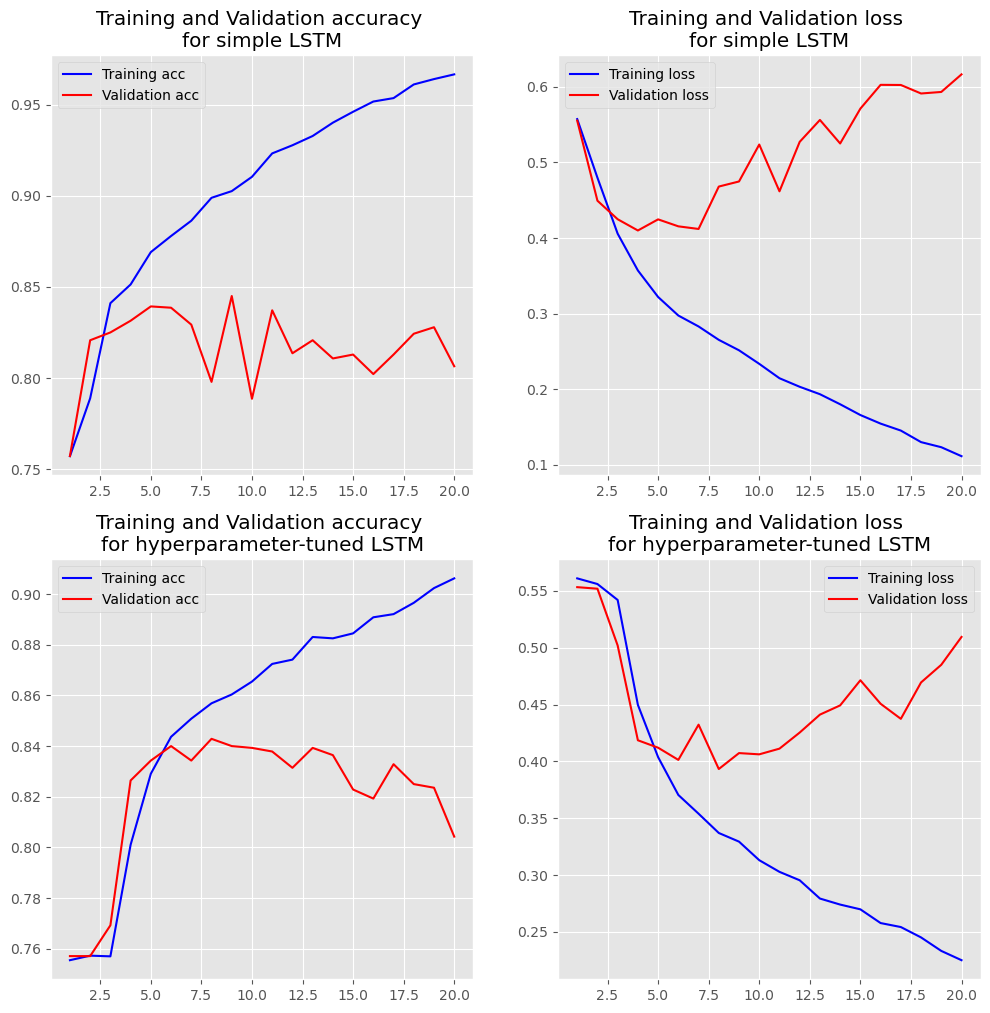

In [30]:
#graph for Training and Validation accuracy and loss comparision
plt.style.use('ggplot')

def plot_history(history1, history2, m, n):
    
    acc = history1.history['accuracy']
    val_acc = history1.history['val_accuracy']
    loss = history1.history['loss']
    val_loss = history1.history['val_loss']
    
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 12))
    
    plt.subplot(2, 2, 1) 
    plt.plot(x, acc, 'blue', label = 'Training acc')
    plt.plot(x, val_acc, 'red', label = 'Validation acc')
    plt.title('Training and Validation accuracy \nfor {}'.format(m))  
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(x, loss, 'blue', label = 'Training loss')
    plt.plot(x, val_loss, 'red', label = 'Validation loss')
    plt.title('Training and Validation loss \nfor {}'.format(m))
    plt.legend()
    
    
    acc = history2.history['accuracy']
    val_acc = history2.history['val_accuracy']
    loss = history2.history['loss']
    val_loss = history2.history['val_loss']
    
    plt.subplot(2, 2, 3) 
    plt.plot(x, acc, 'blue', label = 'Training acc')
    plt.plot(x, val_acc, 'red', label = 'Validation acc')
    plt.title('Training and Validation accuracy \nfor {}'.format(n))  
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.plot(x, loss, 'blue', label = 'Training loss')
    plt.plot(x, val_loss, 'red', label = 'Validation loss')
    plt.title('Training and Validation loss \nfor {}'.format(n))
    plt.legend()
    
plot_history(history, history2, "simple LSTM", "hyperparameter-tuned LSTM")

## **LSTM parameter-tuned Prediction**

In [31]:
# Accuracy score and classification report func
def accuracy_classificationrep( model, y_test, y_pred, show_pred ):
    
    if (show_pred):
        print('\n{} prediction for test data: {}\n'.format(model, y_pred))

    score = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict = True)

    target_names = ['0(non-sexist)', '1(sexist)']

    print("\n{} accuracy score : {}".format(model, score))
    print( "\n{} classification report :\n{}\n".format( model, classification_report(y_test, y_pred, 
                                                                                     target_names = target_names ) ) )
    return report

In [32]:
#Prediction
prediction = model2.predict (x_test)
# print ('\nprediction value: ', prediction)

def pred_labels( prediction ):
  y_pred = []
  for i in prediction:
      if i >= 0.5:
          y_pred.append(1)
      else:
          y_pred.append(0)
  return y_pred

y_pred = pred_labels( prediction )

# print ('\nlist of y PREDICTED sexism: ', y_pred)
# print ('\nlist of y TESTED sexism: ', y_test)

lstm_report = accuracy_classificationrep( "LSTM Hyperparameter-tuned", y_test, y_pred, False )
# print( lstm_report )

44/44 [==============================] - 0s 5ms/step

LSTM Hyperparameter-tuned accuracy score : 0.8064285714285714

LSTM Hyperparameter-tuned classification report :
               precision    recall  f1-score   support

0(non-sexist)       0.88      0.86      0.87      1060
    1(sexist)       0.60      0.63      0.61       340

     accuracy                           0.81      1400
    macro avg       0.74      0.75      0.74      1400
 weighted avg       0.81      0.81      0.81      1400




### **Confusion matrix and Heat-map**

In [33]:
# Confusion Matrix func
def confusionMatrix(s, y_test, predict):

    cm = confusion_matrix( y_test, predict)
    crosstab = pd.crosstab(y_test, predict, rownames = ['Actual'], colnames =['Predicted'], margins = True)
    print("\n{} confusion matrix :\n {}".format(s, crosstab))

    return cm


# Plot Heat-map func
def plot_heat_map(s, cm, cmap):

    class_names = ['non-sexist', 'sexist']
    fig, ax = plot_confusion_matrix( conf_mat = cm, figsize = (5, 5), colorbar = True, show_absolute = True, 
                                show_normed = True, cmap = cmap, class_names=class_names )

    plt.ylabel("Predicted sexism for {}\n".format(s), fontsize = 10)
    plt.xlabel("True sexism for {}".format(s), fontsize = 10)
    plt.title("\nHeat-map of confusion matrix Predicted sexism \nversus True sexism for {}".format(s), fontsize = 10)
    
    plt.show()


LSTM hyperparameter-tuned confusion matrix :
 Predicted     0    1   All
Actual                    
0           916  144  1060
1           127  213   340
All        1043  357  1400


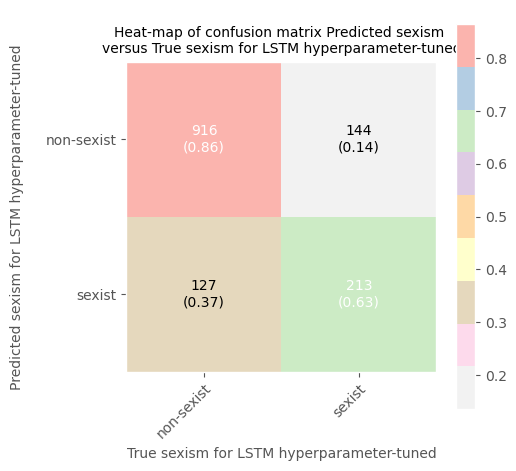

In [34]:
#Confusion matrix for LSTM
cm_lstm_hyper = confusionMatrix("LSTM hyperparameter-tuned", y_test, y_pred)

#Heat-map for LSTM
plot_heat_map("LSTM hyperparameter-tuned", cm_lstm_hyper, plt.cm.Pastel1_r)

# **Imbalance in dataset checking**
Here we see an imbalance, the sexist class is much lesser in amount than the non sexist class and this imbalance needs to be handled to tackle overfitting problem. We will handle it in two ways - **class weight assignment** and **oversampling via synthetic data generation using SMOTE**

In [35]:
print( y_train.value_counts() )

0    8482
1    2718
Name: binary_sexism, dtype: int64


## **Class weight assignment**

In [36]:
from sklearn.utils import class_weight

unique_classes = list( df['binary_sexism'].unique() )
print(unique_classes)

out_dict = {}
for classes in unique_classes:
    out_dict[classes] = df.shape[0] / ( ( df.loc[ df['binary_sexism'] == classes ].shape[0] ) * len(unique_classes) )

print( "\nThe class weights are: ", out_dict )

manual_weights = { 0: 1, 1: 7 }       

class_weights = class_weight.compute_class_weight( class_weight = "balanced", classes = np.unique( y_train ), y = y_train )
class_weights = dict( enumerate( class_weights ) )

[0, 1]

The class weights are:  {0: 0.6602527824938691, 1: 2.0600353148911124}


In [37]:
#fitting model
batch_size = 64

history = model2.fit( x_train, y_train, epochs = 20, class_weight = manual_weights, 
                     verbose = True, validation_data = ( x_val, y_val ), batch_size = batch_size )

# history = model2.fit( x_train, y_train, epochs = 10, class_weight = class_weights, 
#                      verbose = True, validation_data = ( x_val, y_val ), batch_size = batch_size )

Epoch 1/20
175/175 [==============================] - 12s 65ms/step - loss: 0.6468 - accuracy: 0.8304 - val_loss: 0.6235 - val_accuracy: 0.7293
Epoch 2/20
175/175 [==============================] - 11s 65ms/step - loss: 0.5844 - accuracy: 0.8478 - val_loss: 0.7969 - val_accuracy: 0.6757
Epoch 3/20
175/175 [==============================] - 11s 65ms/step - loss: 0.5363 - accuracy: 0.8616 - val_loss: 0.7216 - val_accuracy: 0.7043
Epoch 4/20
175/175 [==============================] - 11s 64ms/step - loss: 0.5285 - accuracy: 0.8602 - val_loss: 0.6373 - val_accuracy: 0.7314
Epoch 5/20
175/175 [==============================] - 11s 65ms/step - loss: 0.4961 - accuracy: 0.8729 - val_loss: 0.6991 - val_accuracy: 0.7164
Epoch 6/20
175/175 [==============================] - 11s 64ms/step - loss: 0.4851 - accuracy: 0.8715 - val_loss: 0.6712 - val_accuracy: 0.7464
Epoch 7/20
175/175 [==============================] - 11s 65ms/step - loss: 0.4721 - accuracy: 0.8729 - val_loss: 0.7122 - val_accuracy:

In [38]:
loss, accuracy = model2.evaluate( x_train, y_train, verbose = False )
print( "\nAfter Class Weight Assignment - Training Accuracy: {:.4f}, Training Loss: {:.4f}".format(accuracy, loss) )

loss, accuracy = model2.evaluate( x_test, y_test, verbose = False )
print( "After Class Weight Assignment - Testing Accuracy:  {:.4f}, Testing Loss: {:.4f}\n".format(accuracy, loss) )

# print(history.history)


After Class Weight Assignment - Training Accuracy: 0.9578, Training Loss: 0.1130
After Class Weight Assignment - Testing Accuracy:  0.7764, Testing Loss: 0.7397



### **Prediction after class-weight assignmnet**

In [39]:
#Prediction after class weights
prediction = model2.predict (x_test)
y_pred = pred_labels( prediction )
lstm_report_cw = accuracy_classificationrep( "LSTM after class-weight assignment", y_test, y_pred, False )

44/44 [==============================] - 0s 5ms/step

LSTM after class-weight assignment accuracy score : 0.7764285714285715

LSTM after class-weight assignment classification report :
               precision    recall  f1-score   support

0(non-sexist)       0.88      0.81      0.85      1060
    1(sexist)       0.53      0.66      0.59       340

     accuracy                           0.78      1400
    macro avg       0.71      0.74      0.72      1400
 weighted avg       0.80      0.78      0.78      1400




### **Confusion matrix and Heatmap**


LSTM Class-Weight Assignment confusion matrix :
 Predicted    0    1   All
Actual                   
0          862  198  1060
1          115  225   340
All        977  423  1400


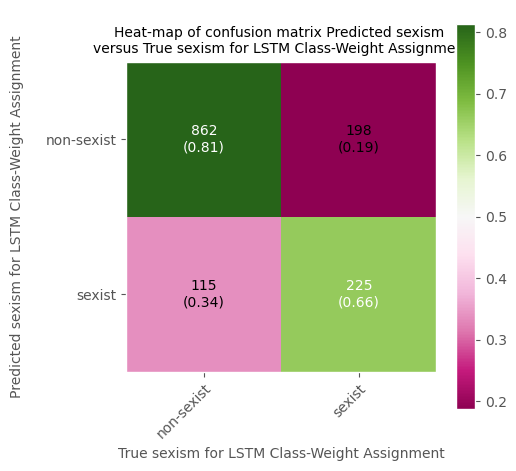

In [40]:
#Confusion matrix
cm_lstm_cw = confusionMatrix("LSTM Class-Weight Assignment", y_test, y_pred)

#Heat-map
plot_heat_map("LSTM Class-Weight Assignment", cm_lstm_cw, plt.cm.PiYG)

## **SMOTE**

In [41]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy = 'minority')
xtrain_sm, ytrain_sm = smote.fit_resample( x_train, y_train )

print("After resampling with SMOTE, unique counts in y_train:\n", ytrain_sm.value_counts())
print("\nx_train after resampling: \n", xtrain_sm)

After resampling with SMOTE, unique counts in y_train:
 1    8482
0    8482
Name: binary_sexism, dtype: int64

x_train after resampling: 
 [[  52   52   18 ...    0    0    0]
 [ 229  126   17 ...    0    0    0]
 [  75    2  199 ...    0    0    0]
 ...
 [   2   48   58 ...    0    0    0]
 [ 247  906 1051 ...    0    0    0]
 [ 180   20 1409 ...    0    0    0]]


In [42]:
#fitting model
batch_size = 64
history2 = model2.fit( xtrain_sm, ytrain_sm, epochs = 20, verbose = True, validation_data = ( x_val, y_val ), batch_size = batch_size )

Epoch 1/20
266/266 [==============================] - 20s 73ms/step - loss: 0.5233 - accuracy: 0.7435 - val_loss: 0.6147 - val_accuracy: 0.7207
Epoch 2/20
266/266 [==============================] - 19s 72ms/step - loss: 0.4648 - accuracy: 0.7736 - val_loss: 0.5841 - val_accuracy: 0.7593
Epoch 3/20
266/266 [==============================] - 19s 71ms/step - loss: 0.4192 - accuracy: 0.7988 - val_loss: 0.6398 - val_accuracy: 0.7221
Epoch 4/20
266/266 [==============================] - 20s 73ms/step - loss: 0.3841 - accuracy: 0.8232 - val_loss: 0.6226 - val_accuracy: 0.7550
Epoch 5/20
266/266 [==============================] - 19s 72ms/step - loss: 0.3494 - accuracy: 0.8433 - val_loss: 0.6832 - val_accuracy: 0.7150
Epoch 6/20
266/266 [==============================] - 19s 72ms/step - loss: 0.3230 - accuracy: 0.8602 - val_loss: 0.6254 - val_accuracy: 0.7514
Epoch 7/20
266/266 [==============================] - 19s 72ms/step - loss: 0.3023 - accuracy: 0.8708 - val_loss: 0.6130 - val_accuracy:

In [43]:
loss, accuracy = model2.evaluate( xtrain_sm, ytrain_sm, verbose = False )
print( "\nAfter SMOTE - Training Accuracy: {:.4f}, Training Loss: {:.4f}".format(accuracy, loss) )

losstest, accuracytest = model2.evaluate( x_test, y_test, verbose = False )
print( "After SMOTE - Testing Accuracy:  {:.4f}, Testing Loss: {:.4f}\n".format(accuracytest, losstest) )

#Storing the best results on imbalance-handled dataset
best_lstmbalance_accloss = [loss, accuracy, losstest, accuracytest, history2]

# print(history2.history)


After SMOTE - Training Accuracy: 0.9848, Training Loss: 0.0537
After SMOTE - Testing Accuracy:  0.7986, Testing Loss: 0.7505



### **Prediction after SMOTE**

In [44]:
#Prediction after SMOTE
prediction = model2.predict (x_test)
y_pred = pred_labels( prediction )
lstm_report_sm = accuracy_classificationrep( "LSTM after SMOTE", y_test, y_pred, False )

44/44 [==============================] - 0s 5ms/step

LSTM after SMOTE accuracy score : 0.7985714285714286

LSTM after SMOTE classification report :
               precision    recall  f1-score   support

0(non-sexist)       0.87      0.86      0.87      1060
    1(sexist)       0.58      0.59      0.59       340

     accuracy                           0.80      1400
    macro avg       0.73      0.73      0.73      1400
 weighted avg       0.80      0.80      0.80      1400




### **Confusion matrix and Heatmap**


LSTM SMOTE confusion matrix :
 Predicted     0    1   All
Actual                    
0           916  144  1060
1           138  202   340
All        1054  346  1400


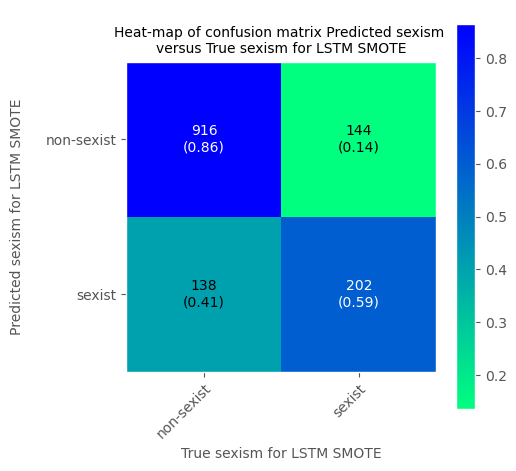

In [45]:
#Confusion matrix
cm_lstm_smote = confusionMatrix("LSTM SMOTE", y_test, y_pred)

#Heat-map
plot_heat_map("LSTM SMOTE", cm_lstm_smote, plt.cm.winter_r)

## **Training & Validation loss & accuracy Graph comparing Class-weight & SMOTE**

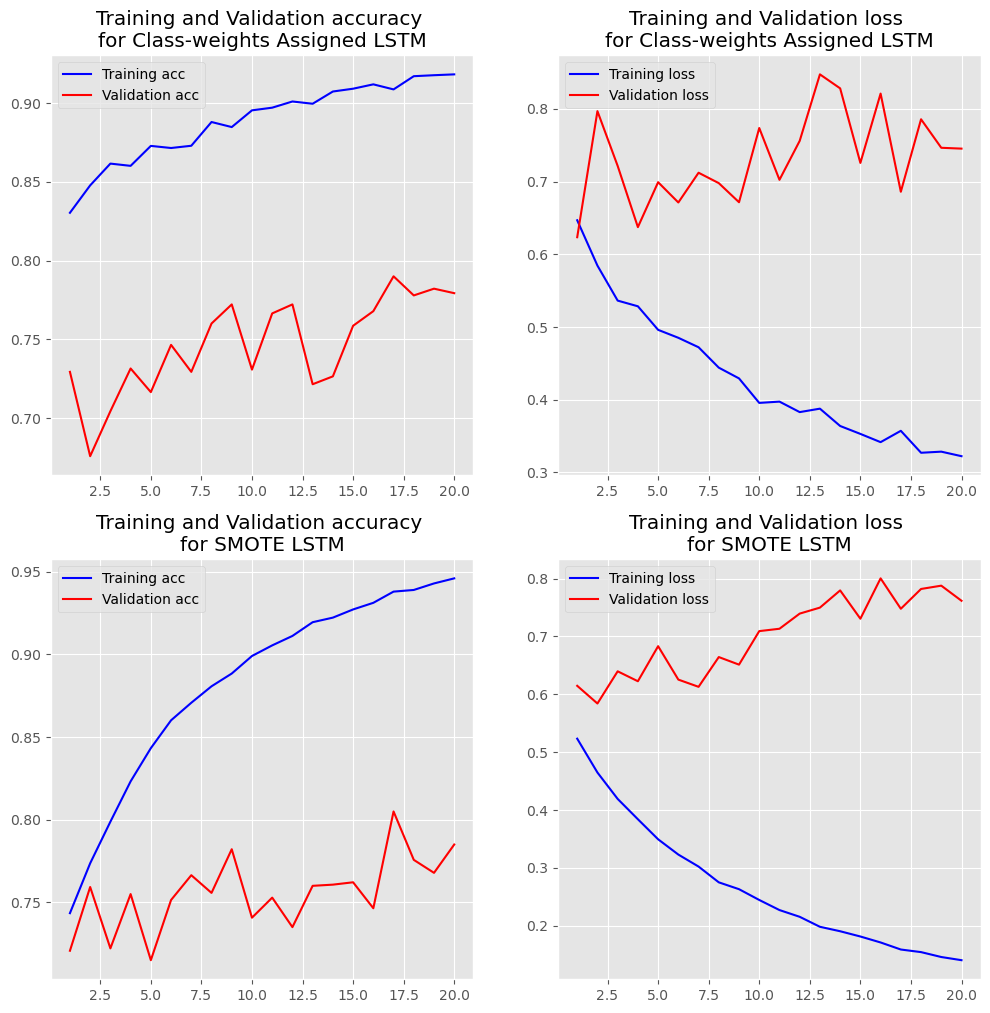

In [46]:
plot_history(history, history2, "Class-weights Assigned LSTM", "SMOTE LSTM")

## **Bargraphs Comparing**

In [47]:
model_names = ['Lstm-Parameter-tuned', 'Lstm-Class-weights', 'Lstm-SMOTE']

colors = ['rosybrown', 'lightsteelblue', 'indianred', 'lightseagreen', 'salmon', 'cornflowerblue']

nonsexist_scores = {
                    'f1-score': [lstm_report['0']['f1-score'], lstm_report_cw['0']['f1-score'], lstm_report_sm['0']['f1-score']], 
                    'precision': [lstm_report['0']['precision'], lstm_report_cw['0']['precision'], lstm_report_sm['0']['precision']],
                    'recall': [lstm_report['0']['recall'], lstm_report_cw['0']['recall'], lstm_report_sm['0']['recall']]
                    }
sexist_scores = {
                    'f1-score': [lstm_report['1']['f1-score'], lstm_report_cw['1']['f1-score'], lstm_report_sm['1']['f1-score']], 
                    'precision': [lstm_report['1']['precision'], lstm_report_cw['1']['precision'], lstm_report_sm['1']['precision']],
                    'recall': [lstm_report['1']['recall'], lstm_report_cw['1']['recall'], lstm_report_sm['1']['recall']]
                    }

### **Bar Graph precision, recall & f1-score**

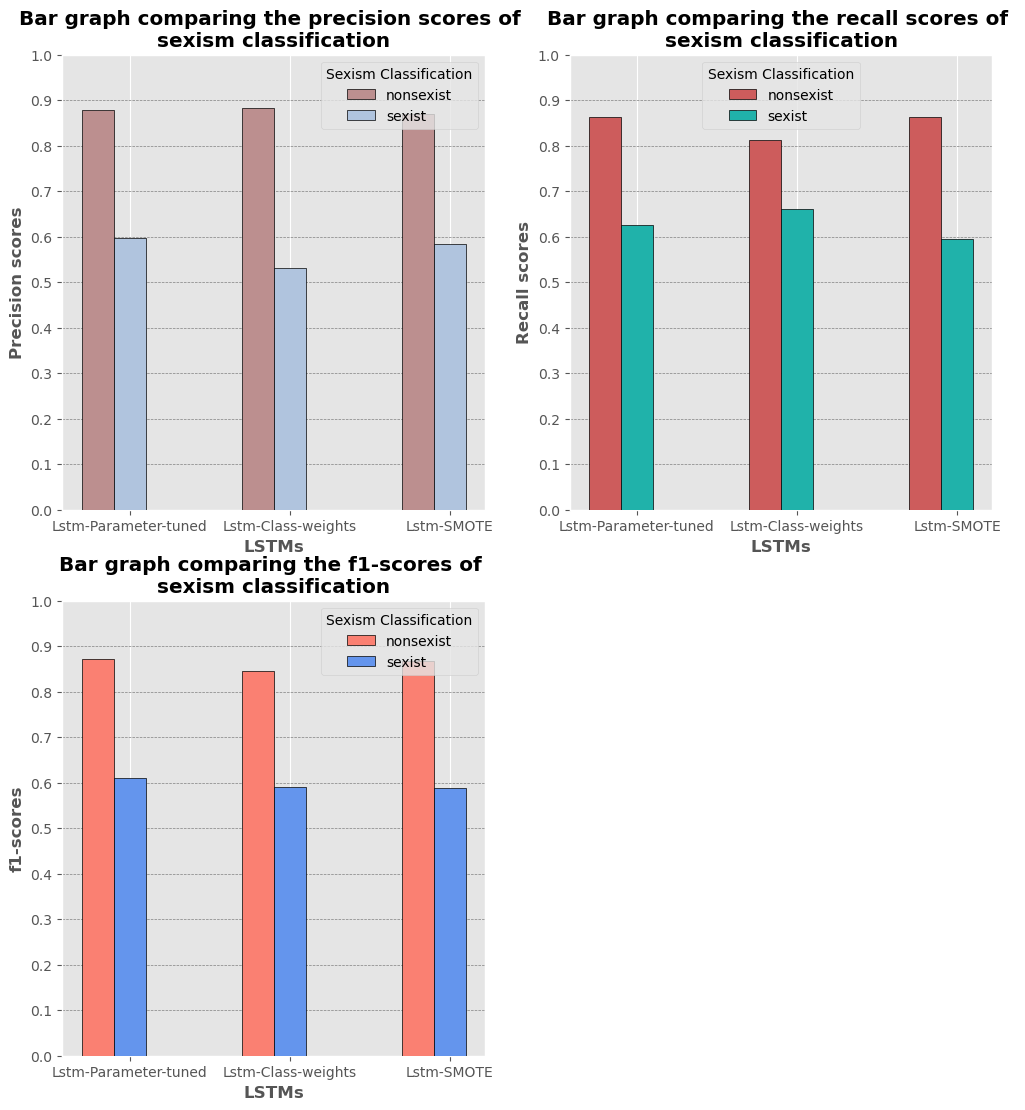

In [48]:
# Plot Bar Graph for comparing precision, recall & f1-score
barWidth = 0.2

# Set position of bar on X axis
br1 = np.arange(len(model_names))
br2 = [x + barWidth for x in br1]   
    
fig = plt.figure(figsize =(12, 13))
    
    
#For comparing precision
plt.subplot(2, 2, 1) 

plt.ylim(0.0, 1.0)
plt.bar(br1, nonsexist_scores["precision"], color =colors[0], edgecolor ='black', width = barWidth, label ='nonsexist', zorder = 3)
plt.bar(br2, sexist_scores["precision"], color =colors[1], edgecolor ='black', width = barWidth, label ='sexist', zorder = 3)

# Adding labels and ticks
plt.xlabel("LSTMs", fontweight ='bold')
plt.ylabel("Precision scores", fontweight ='bold')
plt.title("Bar graph comparing the precision scores of \nsexism classification", fontweight ='bold')

plt.xticks( [ r + barWidth for r in range( len(model_names) ) ], model_names )
plt.yticks( np.arange( 0.0, 1.1, 0.1 ) )

plt.legend(title='Sexism Classification')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5, zorder = 0, axis = 'y')


#For comparing recall
plt.subplot(2, 2, 2) 

plt.ylim(0.0, 1.0)
plt.bar(br1, nonsexist_scores["recall"], color =colors[2], edgecolor ='black', width = barWidth, label ='nonsexist', zorder = 3)
plt.bar(br2, sexist_scores["recall"], color =colors[3], edgecolor ='black', width = barWidth, label ='sexist', zorder = 3)

plt.xlabel("LSTMs", fontweight ='bold')
plt.ylabel("Recall scores", fontweight ='bold')
plt.title("Bar graph comparing the recall scores of \nsexism classification", fontweight ='bold')

plt.xticks( [ r + barWidth for r in range( len(model_names) ) ], model_names )
plt.yticks( np.arange( 0.0, 1.1, 0.1 ) )

plt.legend(title='Sexism Classification')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5, zorder = 0, axis = 'y')


#For comparing f1-scores
plt.subplot(2, 2, 3) 

plt.ylim(0.0, 1.0)
plt.bar(br1, nonsexist_scores["f1-score"], color =colors[4], edgecolor ='black', width = barWidth, label ='nonsexist', zorder = 3)
plt.bar(br2, sexist_scores["f1-score"], color =colors[5], edgecolor ='black', width = barWidth, label ='sexist', zorder = 3)

plt.xlabel("LSTMs", fontweight ='bold')
plt.ylabel("f1-scores", fontweight ='bold')
plt.title("Bar graph comparing the f1-scores of \nsexism classification", fontweight ='bold')

plt.xticks( [ r + barWidth for r in range( len(model_names) ) ], model_names )
plt.yticks( np.arange( 0.0, 1.1, 0.1 ) )

plt.legend(title='Sexism Classification')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5, zorder = 0, axis = 'y')


plt.show()

### **Bargraph showing 4 performance metrics**

[0.7374372567819074, 0.7453107658157603, 0.7411636447488079, 0.8064285714285714]
[0.707103813236351, 0.7374861265260821, 0.7180599280287165, 0.7764285714285715]
[0.7264426188151933, 0.729134295227525, 0.7277624389396251, 0.7985714285714286]


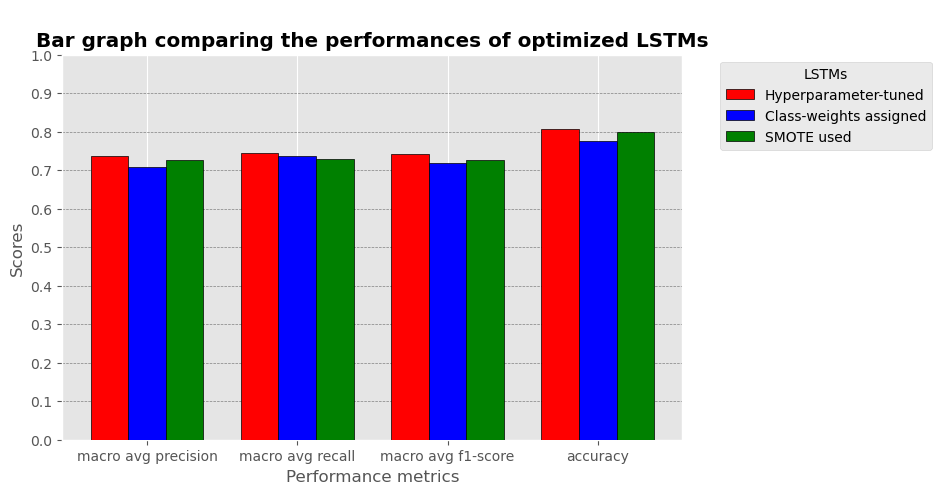

In [49]:
#Bargraph showing 4 performance metrics for these models
barWidth = 0.25
fig = plt.subplots(figsize =(8, 5))

metrics = ['macro avg precision', 'macro avg recall', 'macro avg f1-score', 'accuracy']

lstm = [lstm_report['macro avg']['precision'], lstm_report['macro avg']['recall'], 
        lstm_report['macro avg']['f1-score'], lstm_report['accuracy']]

lstm_cw = [lstm_report_cw['macro avg']['precision'], lstm_report_cw['macro avg']['recall'], 
        lstm_report_cw['macro avg']['f1-score'], lstm_report_cw['accuracy']]

lstm_sm = [lstm_report_sm['macro avg']['precision'], lstm_report_sm['macro avg']['recall'], 
        lstm_report_sm['macro avg']['f1-score'], lstm_report_sm['accuracy']]

print(lstm)
print(lstm_cw)
print(lstm_sm)

# Set position of bar on X axis
br1 = np.arange(len(metrics))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.ylim(0.0, 1.0)
plt.bar(br1, lstm, color = 'red', edgecolor = 'black', width = barWidth, label = 'Hyperparameter-tuned', zorder = 3)
plt.bar(br2, lstm_cw, color = 'blue', edgecolor = 'black', width = barWidth, label = 'Class-weights assigned', zorder = 3)
plt.bar(br3, lstm_sm, color = 'green', edgecolor = 'black', width = barWidth, label = 'SMOTE used', zorder = 3)

# Adding labels and ticks
plt.xlabel("Performance metrics")
plt.ylabel("Scores")
plt.title("\nBar graph comparing the performances of optimized LSTMs", fontweight ='bold')

plt.xticks( [ r + barWidth for r in range( len(metrics) ) ], metrics )
plt.yticks( np.arange( 0.0, 1.1, 0.1 ) )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='LSTMs')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5, zorder = 0, axis = 'y')
plt.show()

In [50]:
#best among imbalanced data
best_performance = { 'lossacchis': best_lstm_accloss, 'classification_report': lstm_report }
#best among imbalance-handled data
best_performance_balance = { 'lossacchis': best_lstmbalance_accloss, 'classification_report': lstm_report_sm }

print('============================================\n', best_performance['lossacchis'], '\n')
print('============================================\n', best_performance['classification_report'], '\n')

print('============================================\n', best_performance_balance['lossacchis'], '\n')
print('============================================\n', best_performance_balance['classification_report'])

 [0.17695054411888123, 0.9301785826683044, 0.4899772107601166, 0.8064285516738892, <keras.callbacks.History object at 0x000002CE008C35B0>] 

 {'0': {'precision': 0.87823585810163, 'recall': 0.8641509433962264, 'f1-score': 0.8711364717070852, 'support': 1060}, '1': {'precision': 0.5966386554621849, 'recall': 0.6264705882352941, 'f1-score': 0.6111908177905307, 'support': 340}, 'accuracy': 0.8064285714285714, 'macro avg': {'precision': 0.7374372567819074, 'recall': 0.7453107658157603, 'f1-score': 0.7411636447488079, 'support': 1400}, 'weighted avg': {'precision': 0.8098479660320504, 'recall': 0.8064285714285714, 'f1-score': 0.8080068128987791, 'support': 1400}} 

 [0.05368068441748619, 0.9847913384437561, 0.7505041360855103, 0.7985714077949524, <keras.callbacks.History object at 0x000002CE04A72C70>] 

 {'0': {'precision': 0.8690702087286527, 'recall': 0.8641509433962264, 'f1-score': 0.8666035950804163, 'support': 1060}, '1': {'precision': 0.5838150289017341, 'recall': 0.5941176470588235, 